#**Final Exam - 0001**


In [115]:
import gdown

files = {
    '1aMJEMz9Je1dsjowOl8NkvPudUEmRv2vt': 'input_file.csv',
    '1aOTgHbwSodY-3La-XlhCbT-7NoJ_6KRy': 'output_file.csv'
}

for file_id, file_name in files.items():
    gdown.download(f"https://drive.google.com/uc?export=download&id={file_id}", file_name, quiet=False)

Downloading...
From: https://drive.google.com/uc?export=download&id=1aMJEMz9Je1dsjowOl8NkvPudUEmRv2vt
To: /content/input_file.csv
100%|██████████| 2.73k/2.73k [00:00<00:00, 8.03MB/s]
Downloading...
From: https://drive.google.com/uc?export=download&id=1aOTgHbwSodY-3La-XlhCbT-7NoJ_6KRy
To: /content/output_file.csv
100%|██████████| 1.02k/1.02k [00:00<00:00, 3.23MB/s]


#**Câu 1 (3 điểm)**
- Cho n cái gáo nước, mỗi gáo i có thể chứa tối đa ai lít nước. Bạn cần múc đúng M lít nước từ bờ sông qua bể nước lớn với số thao tác ít nhất, không được múc quá cũng như múc thiếu. Biết, bạn không có bất kỳ dụng cụ nào khác để đo số lượng nước. Bạn cũng có thể vứt bỏ số nước đã múc nếu cần và việc vứt bỏ này không tính là số thao tác.

Hãy viết chương trình sử dụng thuật toán A* nhập vào các số nguyên n, M và a1, a2,…,an và in ra cách thức múc nước. Nếu không có đáp án thì in “Không có đáp án”.

Ví dụ:

- Nhập: 2 5 4 3

- Xuất:

o Chuyển/Múc 4 lít nước từ bờ sông qua gáo 1 (Gáo 1: 4 lít, Gáo 2: 0 lít, Bể: 0 lít)

o Chuyển/Múc 4 lít nước từ gáo 1 qua bể (Gáo 1: 0 lít, Gáo 2: 0 lít, Bể: 4 lít)

o Chuyển/Múc 4 lít nước từ bờ sông qua gáo 1 (Gáo 1: 4 lít, Gáo 2: 0 lít, Bể: 4 lít)

o Chuyển/Múc 3 lít nước từ gáo 1 qua gáo 2 (Gáo 1: 1 lít, Gáo 2: 3 lít, Bể: 4 lít)

o Chuyển/Múc 1 lít nước từ gáo 1 qua bể (Gáo 1: 0 lít, Gáo 2: 3 lít, Bể: 5 lít)

In [116]:
import heapq
import math
# Một số luật ngầm có thể hiểu như sau: Đổ hết nước hoặc đổ cho tới khi đầy gáo kia => tự suy ra phần còn lại trong gáo (không có công cụ đo mà)
# Không thể đổ dư mức đầy của bể.
class State:
    def __init__(self, jars, tank, actions=[]):
        self.jars = tuple(jars)  # Gáo
        self.tank = tank  # Bể
        self.actions = actions
        #self.river = int(math.inf)

    def __lt__(self, other):
        return self.tank < other.tank

    def __eq__(self, other):
        return self.jars == other.jars and self.tank == other.tank

    def __hash__(self):
        return hash((self.jars, self.tank))

def heuristic(state, M):
    return abs(M - state.tank)

def state_info(jars, tank):
    return f"({' , '.join(f'Gáo {i+1}: {jar} lít' for i, jar in enumerate(jars))}, Bể: {tank} lít)"

def get_neighbors(state, max_jars, M):
    neighbors = []
    n = len(state.jars)

    # Sông - Gáo
    for i in range(n):
        if state.jars[i] < max_jars[i]:
            new_jars = list(state.jars)
            new_jars[i] = max_jars[i]
            new_actions = state.actions + [f"Chuyển/Múc {max_jars[i]} lít nước từ bờ sông qua gáo {i + 1}.", state_info(new_jars, state.tank)]
            neighbors.append(State(new_jars, state.tank, new_actions))

    # Gáo - Bể
    for i in range(n):
        if state.jars[i] > 0:
            new_jars = list(state.jars)
            potential_tank = state.tank + state.jars[i]
            if potential_tank <= M:
                new_jars[i] = 0
                new_actions = state.actions + [f"Chuyển/Múc {state.jars[i]} lít nước từ gáo {i + 1} qua bể.", state_info(new_jars, potential_tank)]
                neighbors.append(State(new_jars, potential_tank, new_actions))

    # Gáo - Gáo
    for i in range(n):
        for j in range(n):
            if i != j and state.jars[i] > 0 and state.jars[j] < max_jars[j]:
                transfer_amount = min(state.jars[i], max_jars[j] - state.jars[j])
                new_jars = list(state.jars)
                new_jars[i] -= transfer_amount
                new_jars[j] += transfer_amount
                new_actions = state.actions + [f"Chuyển/Múc {transfer_amount} lít nước từ gáo {i + 1} sang gáo {j + 1}.", state_info(new_jars, state.tank)]
                neighbors.append(State(new_jars, state.tank, new_actions))

    return neighbors

def a_star(max_jars, M):
    start_state = State([0] * len(max_jars), 0)
    frontier = [(heuristic(start_state, M), start_state)]
    heapq.heapify(frontier)
    explored = set()

    while frontier:
        _, current_state = heapq.heappop(frontier)

        if current_state.tank == M:
            return current_state.actions

        if current_state in explored:
            continue

        explored.add(current_state)

        for neighbor in get_neighbors(current_state, max_jars, M):
            if neighbor not in explored:
                heapq.heappush(frontier, (heuristic(neighbor, M) + len(neighbor.actions), neighbor))

    return "Hong có đáp án"

In [117]:
n = 3
M = 13
max_jars = [7, 8, 9]

result = a_star(max_jars, M)
if result == "Hong có đáp án":
    print(result)
else:
    for action in result:
        print(action)

Chuyển/Múc 8 lít nước từ bờ sông qua gáo 2.
(Gáo 1: 0 lít , Gáo 2: 8 lít , Gáo 3: 0 lít, Bể: 0 lít)
Chuyển/Múc 8 lít nước từ gáo 2 qua bể.
(Gáo 1: 0 lít , Gáo 2: 0 lít , Gáo 3: 0 lít, Bể: 8 lít)
Chuyển/Múc 7 lít nước từ bờ sông qua gáo 1.
(Gáo 1: 7 lít , Gáo 2: 0 lít , Gáo 3: 0 lít, Bể: 8 lít)
Chuyển/Múc 7 lít nước từ gáo 1 sang gáo 3.
(Gáo 1: 0 lít , Gáo 2: 0 lít , Gáo 3: 7 lít, Bể: 8 lít)
Chuyển/Múc 7 lít nước từ bờ sông qua gáo 1.
(Gáo 1: 7 lít , Gáo 2: 0 lít , Gáo 3: 7 lít, Bể: 8 lít)
Chuyển/Múc 2 lít nước từ gáo 1 sang gáo 3.
(Gáo 1: 5 lít , Gáo 2: 0 lít , Gáo 3: 9 lít, Bể: 8 lít)
Chuyển/Múc 5 lít nước từ gáo 1 qua bể.
(Gáo 1: 0 lít , Gáo 2: 0 lít , Gáo 3: 9 lít, Bể: 13 lít)


#**Câu 2 (4 điểm)**

Cho tập dữ liệu input.csv với 90 mẫu dữ liệu, mỗi mẫu có 4 đặc trưng ( chiều dài đài hoa, chiều rộng đài hoa, chiều dài cánh hoa, chiều rộng cánh hoa) và tên loài hoa tương ứng.

a) (3 điểm) Hãy viết chương trình phân loại hoa sử dụng Logistic Regression kết hợp với lớp softmax. Nêu rõ mô hình thức phân loại trong chương trình như thế nào (Ví dụ: có bao nhiêu tế bào nơ-ron, mỗi nơ-ron phụ trách công việc gì, làm sao để phân loại,…)?

b) (1 điểm) Hãy thực thi chương trình và cho biết nhãn của 60 mẫu dữ liệu trong output.csv

In [118]:
import pandas as pd
import numpy as np

input_df = pd.read_csv('input_file.csv')
input_df.columns = ['ft1', 'ft2', 'ft3', 'ft4', 'label']
input_df

,ft1,ft2,ft3,ft4,label
0,5.1,3.7,1.5,0.4,Iris-setosa
1,4.6,3.6,1.0,0.2,Iris-setosa
2,5.1,3.3,1.7,0.5,Iris-setosa
3,4.8,3.4,1.9,0.2,Iris-setosa
4,5.0,3.0,1.6,0.2,Iris-setosa
...,...,...,...,...,...
84,6.7,3.0,5.2,2.3,Iris-virginica
85,6.3,2.5,5.0,1.9,Iris-virginica
86,6.5,3.0,5.2,2.0,Iris-virginica
87,6.2,3.4,5.4,2.3,Iris-virginica


In [119]:
label_counts = input_df['label'].value_counts()
print(label_counts)
print(np.unique(input_df['label']))

label
Iris-versicolor    30
Iris-virginica     30
Iris-setosa        29
Name: count, dtype: int64
['Iris-setosa' 'Iris-versicolor' 'Iris-virginica']


In [120]:
from sklearn.preprocessing import LabelEncoder

def prepare_data(df):
    features = df.iloc[:, :-1].values
    targets = df.iloc[:, -1].values
    label_encoder = LabelEncoder()

    targets = label_encoder.fit_transform(targets)


    return features, targets, label_encoder

In [121]:
X, y, lb = prepare_data(input_df)
# bias
X = np.hstack((np.ones((X.shape[0], 1)), X))
# print(X)
# print(y)

In [122]:
# Utils
def softmax(z):
    exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))
    return exp_z / np.sum(exp_z, axis=1, keepdims=True)

def cross_entropy_loss(y_true, y_pred):
    n_samples = y_true.shape[0]
    logp = - np.log(y_pred[range(n_samples), y_true])
    loss = np.sum(logp) / n_samples
    return loss

def accuracy(y_true, y_pred):
    return np.mean(y_true == y_pred)

In [123]:
# hyper-params
n_samples, n_features = X.shape
n_classes = len(np.unique(y))
learning_rate = 0.01
n_iterations = 1000

# weights
W = np.zeros((n_features, n_classes))

# training
for i in range(n_iterations):
    scores = np.dot(X, W)
    probs = softmax(scores)
    y_pred = np.argmax(probs, axis=1)
    # gradient descent
    gradient = (1 / n_samples) * np.dot(X.T, probs - np.eye(n_classes)[y])
    W -= learning_rate * gradient
    # acc and loss
    if (i + 1) % 100 == 0:
        loss = cross_entropy_loss(y, probs)
        acc = accuracy(y, y_pred)
        print(f'iter: {i + 1}, accuracy: {acc:.2f}, loss: {loss:.2f}')

iter: 100, accuracy: 0.66, loss: 0.73
iter: 200, accuracy: 0.75, loss: 0.60
iter: 300, accuracy: 0.84, loss: 0.54
iter: 400, accuracy: 0.89, loss: 0.50
iter: 500, accuracy: 0.91, loss: 0.47
iter: 600, accuracy: 0.92, loss: 0.44
iter: 700, accuracy: 0.94, loss: 0.43
iter: 800, accuracy: 0.94, loss: 0.41
iter: 900, accuracy: 0.94, loss: 0.39
iter: 1000, accuracy: 0.96, loss: 0.38


In [124]:
final_probs = softmax(np.dot(X, W))
final_predictions = np.argmax(final_probs, axis=1)

final_acc = accuracy(y, final_predictions)
print(f'Final accuracy: {final_acc:.2f}')

Final accuracy: 0.96


In [125]:
output_df = pd.read_csv('output_file.csv')
output_df.columns = ['ft1', 'ft2', 'ft3', 'ft4']
output_df

,ft1,ft2,ft3,ft4
0,4.9,3.0,1.4,0.2
1,4.7,3.2,1.3,0.2
2,4.6,3.1,1.5,0.2
3,5.0,3.6,1.4,0.2
4,5.4,3.9,1.7,0.4
5,4.6,3.4,1.4,0.3
6,5.0,3.4,1.5,0.2
7,4.4,2.9,1.4,0.2
8,4.9,3.1,1.5,0.1
9,5.4,3.7,1.5,0.2


In [126]:
X_test = output_df.values

X_test = np.hstack((np.ones((X_test.shape[0], 1)), X_test))

test_scores = np.dot(X_test, W)
test_probs = softmax(test_scores)
test_predictions = np.argmax(test_probs, axis=1)
predictions_labels = lb.inverse_transform(test_predictions)

print(test_predictions)
print(predictions_labels)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1
 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
['Iris-setosa' 'Iris-setosa' 'Iris-setosa' 'Iris-setosa' 'Iris-setosa'
 'Iris-setosa' 'Iris-setosa' 'Iris-setosa' 'Iris-setosa' 'Iris-setosa'
 'Iris-setosa' 'Iris-setosa' 'Iris-setosa' 'Iris-setosa' 'Iris-setosa'
 'Iris-setosa' 'Iris-setosa' 'Iris-setosa' 'Iris-setosa' 'Iris-versicolor'
 'Iris-versicolor' 'Iris-versicolor' 'Iris-versicolor' 'Iris-versicolor'
 'Iris-versicolor' 'Iris-versicolor' 'Iris-versicolor' 'Iris-versicolor'
 'Iris-versicolor' 'Iris-versicolor' 'Iris-versicolor' 'Iris-versicolor'
 'Iris-versicolor' 'Iris-versicolor' 'Iris-versicolor' 'Iris-virginica'
 'Iris-versicolor' 'Iris-versicolor' 'Iris-versicolor' 'Iris-virginica'
 'Iris-virginica' 'Iris-virginica' 'Iris-virginica' 'Iris-virginica'
 'Iris-virginica' 'Iris-virginica' 'Iris-virginica' 'Iris-virginica'
 'Iris-virginica' 'Iris-virginica' 'Iris-virginica' 'Iris-virginica'
 'Iris-virginica' 'Ir

#**Câu 3 (3 điểm)**
Cho tập dữ liệu input.csv với 90 mẫu dữ liệu như câu 2, Hãy viết chương trình phân cụm bằng thuật toán k-means

a) (1 điểm) Viết hàm thực thi thuật toán k-means

b) (2 điểm) Nếu sử dụng thuật toán k-means với k = 3 thì kết quả phân nhóm sẽ như thế nào? (Trọng tâm của các cụm, tỷ lệ phân cụm đúng, tiêu chí đánh giá việc phân cụm đúng là gì?).

In [127]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from keras.losses import categorical_crossentropy
import seaborn as sns
from sklearn.decomposition import PCA
np.random.seed(42)

**Giải thích:** Chọn ngẫu nhiên các tâm, với mỗi điểm trong X, tính khoảng cách bình phương D(xi) tới tâm gần nhất đã được chọn. Tính xác xuất theo tỉ lệ p(xi) = D(xi)^2/sigma(D(xi)^2. Rồi sau đó tổng các p(xi) lại, là 1 mảng biểu diễn xác suất tích lũy tới mỗi điểm. Tiếp, sinh ra r ngũâ nhiên trong [0, 1]. Tìm tổng xác suất tích lũy >= r.

In [128]:
# Utils
def kmeans_init_centroids(X, Y, K: int):
    centroids = []
    for k in range(K):
        X_k = X[Y == k]
        centroid_k = X_k[np.random.choice(a = X_k.shape[0], size=1, replace=False)]
        centroids.append(centroid_k)
    return np.concatenate(centroids, axis=0)

# KMeans++ Initialization
def kmeans_plus_plus_init_centroids(X, Y, K):
    centroids = []
    for k in range(K):
        X_k = X[Y == k]
        centroid_k = X_k[np.random.choice(X_k.shape[0], size=1, replace=False)]
        centroids.append(centroid_k)

    centroids = np.concatenate(centroids, axis=0).tolist()

    while len(centroids) < K:
        # Compute the distance squared to the nearest centroid
        D2 = np.min(cdist(X, np.array(centroids))**2, axis=1)
        # Compute probabilities proportional to distance squared
        probs = D2 / np.sum(D2)
        # Compute cumulative sum of probabilities
        cumulative_probs = np.cumsum(probs)
        # Choose the next centroid
        r = np.random.rand()
        index = np.searchsorted(cumulative_probs, r)
        centroids.append(X[index])

    return np.array(centroids)

def kmeans_assign_labels(X, centroids):
    D = cdist(X, centroids)
    return np.argmin(D, axis=1)

# Check convergence
def has_converged(centroids, new_centroids):
    return (set([tuple(a) for a in centroids]) == set([tuple(a) for a in new_centroids]))

def kmeans_update_centroids(X, labels, K: int):
    centroids = np.zeros((K, X.shape[1]))
    for k in range(K):
        Xk = X[labels == k, :]
        centroids[k, :] = np.mean(Xk, axis=0)
    return centroids

def accuracy(labels, targets):
    n_samples = targets.shape[0]
    n_correct = np.sum(labels == targets, axis=0)
    accuracy = n_correct / n_samples
    return accuracy

def loss(labels, targets):
    one_hot_targets = OneHotEncoder().fit_transform(np.expand_dims(targets, axis=1)).toarray()
    one_hot_labels = OneHotEncoder().fit_transform(np.expand_dims(labels, axis=1)).toarray()
    loss = np.mean(categorical_crossentropy(one_hot_labels, one_hot_targets), axis=0)
    return loss

In [129]:
# All the Kmeans
def kmeans(X, Y, K):
    centroids = [kmeans_plus_plus_init_centroids(X, Y, K)]
    labels = []
    targets = Y
    acc = []
    criterion = []
    it = 0
    while True:
        it = it + 1
        labels.append(kmeans_assign_labels(X, centroids[-1]))

        acc_it = accuracy(labels=labels[-1], targets=targets)
        acc.append(acc_it)

        criterion_it = loss(labels=labels[-1], targets=targets)
        criterion.append(criterion_it)

        print(f'iter: {it}, accuracy: {acc[-1]:.2f}, loss: {criterion[-1]:.2f}')

        new_centroids = kmeans_update_centroids(X, labels[-1], K)
        if has_converged(centroids[-1], new_centroids):
            break
        centroids.append(new_centroids)
    return (np.round(centroids[-1], 2), labels[-1])

iter: 1, accuracy: 0.88, loss: 1.99
iter: 2, accuracy: 0.88, loss: 1.99
iter: 3, accuracy: 0.89, loss: 1.81
iter: 4, accuracy: 0.89, loss: 1.81
Centroids: 
[[4.97 3.38 1.48 0.25]
 [5.92 2.78 4.41 1.43]
 [6.84 3.09 5.68 2.08]]


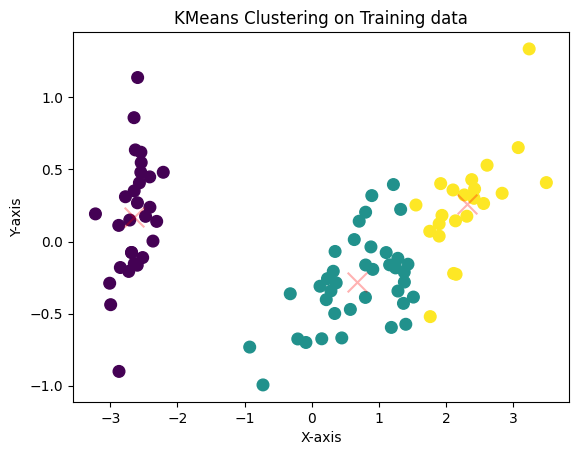

In [130]:
features, targets, lb = prepare_data(input_df)

(centroids, labels) = kmeans(features, targets, 3)
print(f'Centroids: \n{centroids}')

pca = PCA(n_components=2)
features_2d = pca.fit_transform(features)
centroids_2d = pca.transform(centroids)

# plot
plt.scatter(features_2d[:, 0], features_2d[:, 1], c=labels, s=70, cmap='viridis')
plt.scatter(centroids_2d[:, 0], centroids_2d[:, 1], c='red', s=200, alpha=0.3, marker='x')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('KMeans Clustering on Training data')
plt.show()

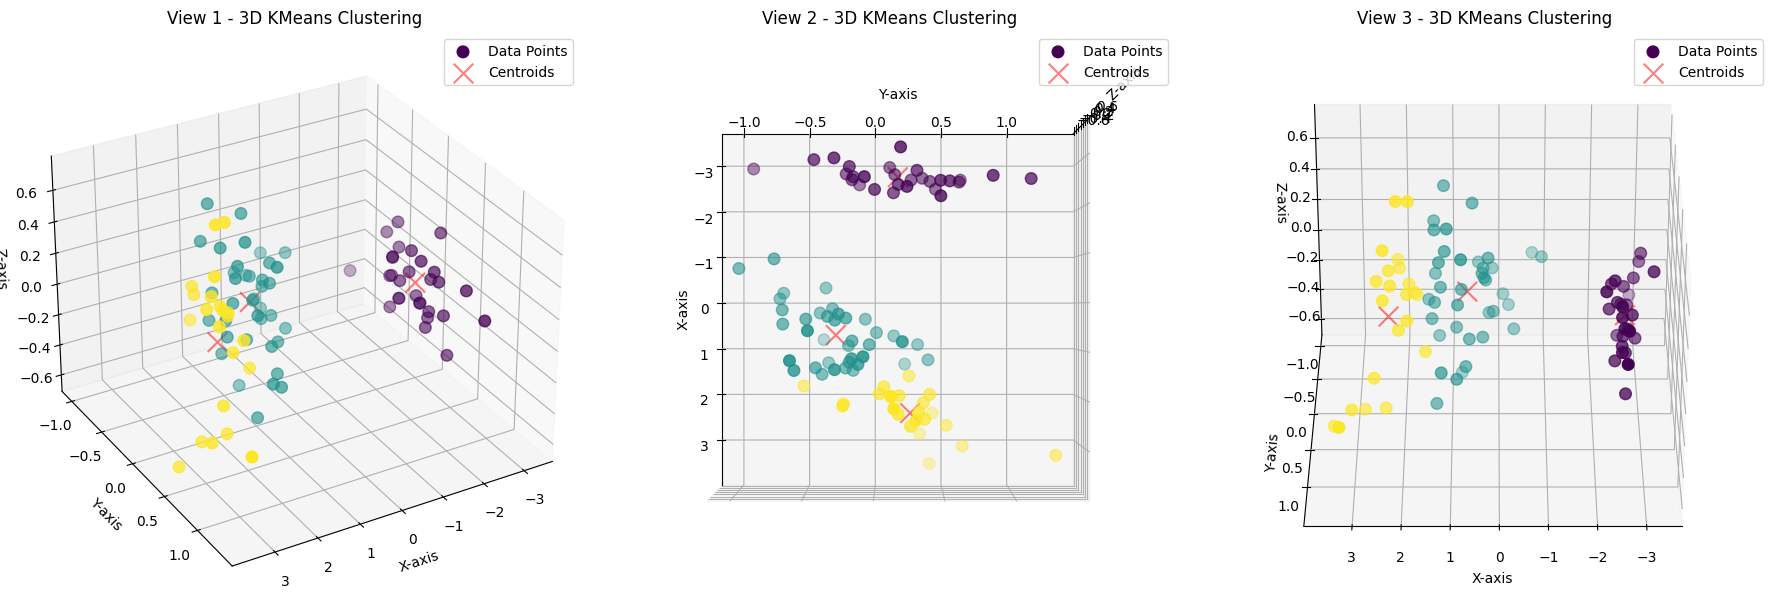

In [131]:
from mpl_toolkits.mplot3d import Axes3D

pca = PCA(n_components=3)
features_3d = pca.fit_transform(features)
centroids_3d = pca.transform(centroids)

fig = plt.figure(figsize=(18, 6))

angles = [(60, 30), (0, 90), (90, 30)]

for i, angle in enumerate(angles, 1):
    ax = fig.add_subplot(1, 3, i, projection='3d')
    scatter = ax.scatter(features_3d[:, 0], features_3d[:, 1], features_3d[:, 2], c=labels, s=70, cmap='viridis', label='Data Points')
    ax.scatter(centroids_3d[:, 0], centroids_3d[:, 1], centroids_3d[:, 2], c='red', s=200, alpha=0.5, marker='x', label='Centroids')
    ax.view_init(elev=angle[1], azim=angle[0])
    ax.set_xlabel('X-axis')
    ax.set_ylabel('Y-axis')
    ax.set_zlabel('Z-axis')
    ax.set_title(f'View {i} - 3D KMeans Clustering')
    ax.legend()

plt.tight_layout()
plt.show()

In [132]:
X_test = output_df.values
km_predictions = kmeans_assign_labels(X_test, centroids)
km_predictions_labels = lb.inverse_transform(km_predictions)

In [133]:
print(km_predictions)
print(km_predictions_labels)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 2 1 2 2 2 2 1 2 2 2 2 2 2 1 1 2 2 2 2 1]
['Iris-setosa' 'Iris-setosa' 'Iris-setosa' 'Iris-setosa' 'Iris-setosa'
 'Iris-setosa' 'Iris-setosa' 'Iris-setosa' 'Iris-setosa' 'Iris-setosa'
 'Iris-setosa' 'Iris-setosa' 'Iris-setosa' 'Iris-setosa' 'Iris-setosa'
 'Iris-setosa' 'Iris-setosa' 'Iris-setosa' 'Iris-setosa' 'Iris-versicolor'
 'Iris-versicolor' 'Iris-virginica' 'Iris-versicolor' 'Iris-versicolor'
 'Iris-versicolor' 'Iris-versicolor' 'Iris-versicolor' 'Iris-versicolor'
 'Iris-versicolor' 'Iris-versicolor' 'Iris-versicolor' 'Iris-versicolor'
 'Iris-versicolor' 'Iris-versicolor' 'Iris-versicolor' 'Iris-versicolor'
 'Iris-versicolor' 'Iris-versicolor' 'Iris-versicolor' 'Iris-virginica'
 'Iris-versicolor' 'Iris-virginica' 'Iris-virginica' 'Iris-virginica'
 'Iris-virginica' 'Iris-versicolor' 'Iris-virginica' 'Iris-virginica'
 'Iris-virginica' 'Iris-virginica' 'Iris-virginica' 'Iris-virginica'
 'Iris-versicolor' 

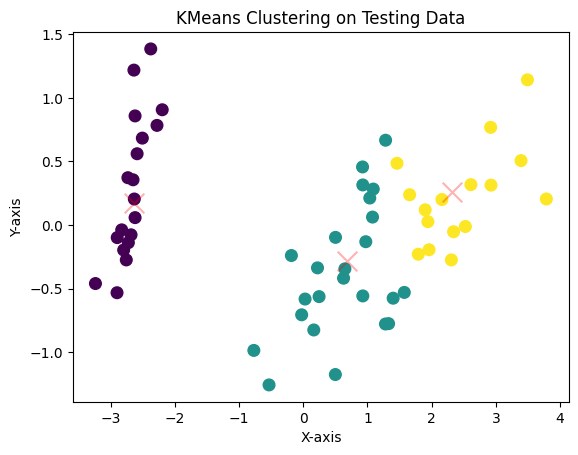

In [134]:
features_test_2d = pca.transform(X_test)

plt.scatter(features_test_2d[:, 0], features_test_2d[:, 1], c=km_predictions, s=70, cmap='viridis')
plt.scatter(centroids_2d[:, 0], centroids_2d[:, 1], c='red', s=200, alpha=0.3, marker='x')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('KMeans Clustering on Testing Data')
plt.show()

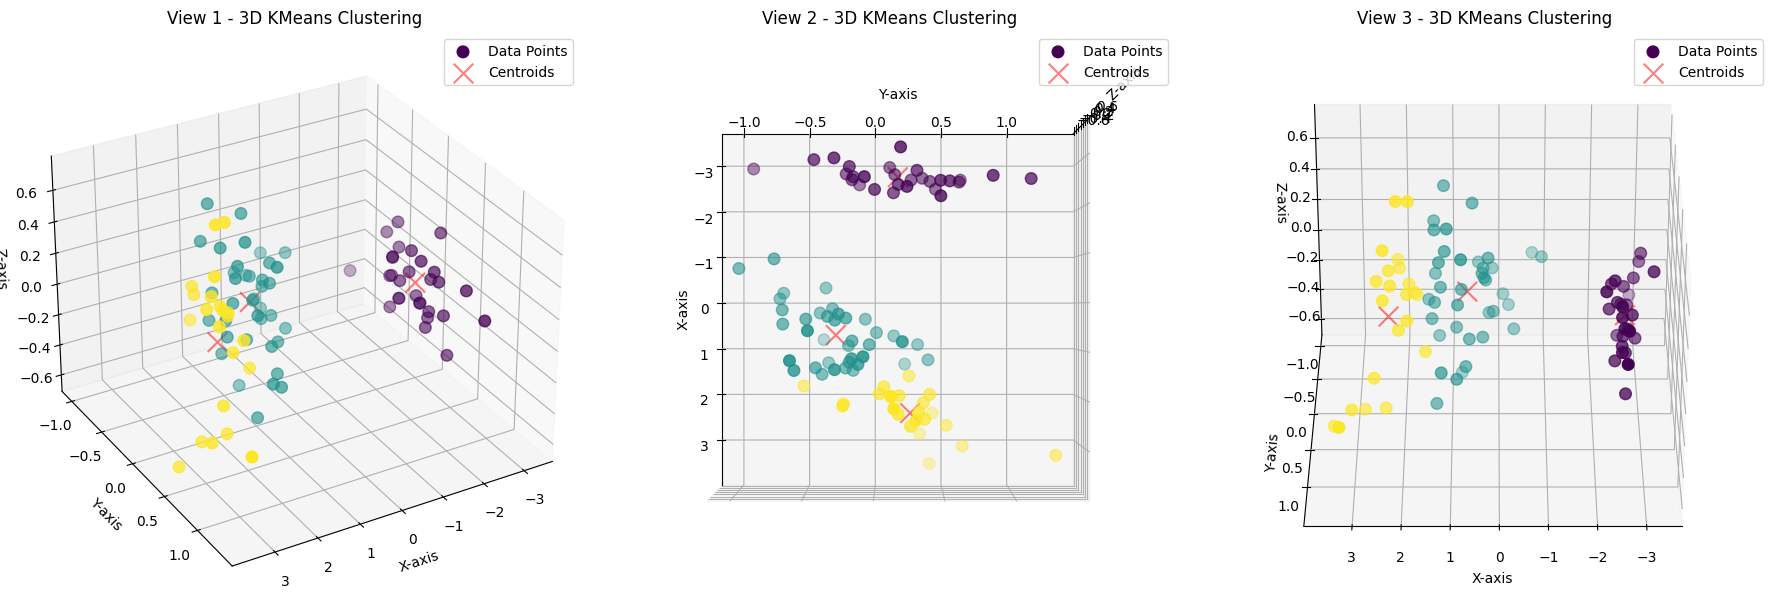

In [135]:
from mpl_toolkits.mplot3d import Axes3D

pca = PCA(n_components=3)
test_features_3d = pca.fit_transform(features)
test_centroids_3d = pca.transform(centroids)

fig = plt.figure(figsize=(18, 6))

angles = [(60, 30), (0, 90), (90, 30)]

for i, angle in enumerate(angles, 1):
    ax = fig.add_subplot(1, 3, i, projection='3d')
    scatter = ax.scatter(test_features_3d[:, 0], test_features_3d[:, 1], test_features_3d[:, 2], c=labels, s=70, cmap='viridis', label='Data Points')
    ax.scatter(test_centroids_3d[:, 0], test_centroids_3d[:, 1], test_centroids_3d[:, 2], c='red', s=200, alpha=0.5, marker='x', label='Centroids')
    ax.view_init(elev=angle[1], azim=angle[0])
    ax.set_xlabel('X-axis')
    ax.set_ylabel('Y-axis')
    ax.set_zlabel('Z-axis')
    ax.set_title(f'View {i} - 3D KMeans Clustering')
    ax.legend()

plt.tight_layout()
plt.show()